# __Analysis of the 2m air temperature data from the _Copernicus Climate Data Store_ (CDS)__

#### For this project, I used the 2m air temperature data from the ERA5 Reanalysis dataset (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) provided by the Copernicus Climate Data Store (CDS). ERA5 is a global climate reanalysis dataset that provides hourly estimates of atmospheric variables, including the 2m air temperature. $\\$ ####
#### The goal of this project is to analyse the 2m air temperature data and visualize it in different ways, to highlight patterns and trends. Various types of plots are used, making it easier to understand temperature changes over time and across different areas.

### __Line plot of the temperature anomalies in Europe from 1940 to 2024__ ###

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
file = 'data_t2m_tot.nc' #2m air temperature
ds = xr.open_dataset(file, chunks = {'valid_time' : 50}) #chunks for faster computation
temp = ds.t2m

C:\Users\teaca\AppData\Local\Temp\ipykernel_14008\855158045.py:2: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(file, chunks = {'valid_time' : 50}) #chunks for faster computation


Define key parameters.

In [3]:
yrs = range(1940, 2025)
months = range(0,12)
locations = {"Hannover": (52.5, 9.75),
             "Helsinki": (60.25, 25),
             "Siena": (43.25, 11.25)}

In [4]:
temp_grp = temp.groupby(['valid_time.month', 'valid_time.year']).mean(dim=['valid_time']) #xarray with shape (:, month, year)
temp_eu_month = temp_grp.mean(dim=['longitude', 'latitude']) #xarray shape: (month, year)
temp_eu_year = temp_eu_month.mean(dim='month') #xarray shape: (year)

Compute the temperature anomalies as the __difference between the mean temperature for each year and month, relative to the value for the year 1940__.

In [5]:
anom_year = temp_eu_year - temp_eu_year.sel(year = 1940) #lazy compute yearly anomaly
anom_year_vals = anom_year.values[:-1] #extract values

In [6]:
loc_anoms = {} #dictionary for better structure
for loc, (lat, lon) in locations.items():
    temp_loc = temp_grp.sel(latitude=lat, longitude=lon).mean(dim='month')
    anom = temp_loc - temp_loc.sel(year = 1940) #lazy compute anomaly for each location
    loc_anoms[loc] = anom.sel(year=yrs).values #extract values

Display the data in a __line plot__. $\\$
This plot shows the __mean yearly temperature anomalies in Europe__. Moreover, I chose to include the temperature anomalies of three different cities, __Hannover, Helsinki, and Siena__, represented by the colored lines. Mostly out of curiosity, as these are places where I’ve lived the longest, adding a personal touch to the project.

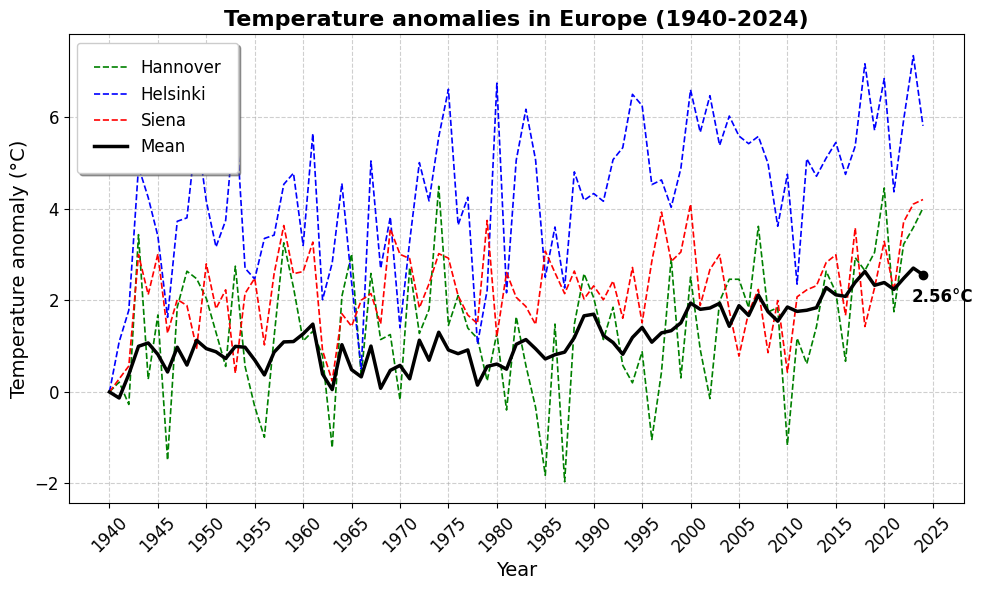

In [ ]:
plt.figure(figsize=(10, 6))

colrs = {"Hannover": "green", "Helsinki": "blue", "Siena": "red"}

for loc, anom in loc_anoms.items():
    plt.plot(yrs, anom, label=loc, color = colrs[loc], linewidth=1.2, linestyle='--')

plt.plot(yrs, anom_year_vals, label='Mean', color='black', linewidth=2.5, linestyle='solid')
plt.plot(2024, anom_year_vals[-1], 'ko')
plt.text(2024 - 1.2, anom_year_vals[-1] - 0.6, f"{anom_year_vals[-1]:.2f}°C", fontsize=12, fontweight = 'bold')

plt.xticks(range(1940, 2026, 5), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature anomaly (°C)", fontsize=14)
plt.title("Temperature anomalies in Europe (1940-2024)", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.savefig('bubbles_eu.png')
plt.show()

#### The plot clearly shows how the effects of climate change are __strongest in the Arctic region__, with Helsinki showing the highest increase. In contrast, Hannover and Siena follow the European average more closely. In 2024, the mean temperature anomaly across Europe reached __2.56 °C__, almost 1°C more than the mean temperature anomaly across the whole world.

### __Scatter plot of the monthly temperature anomalies in Europe between 1940 and 2024__

In [13]:
from matplotlib import colors
import numpy as np

Define key parameters.

In [14]:
step = 4  #interval for selecting years (every 4th year)
start_idx = 4 #start of year to display
sample_years = yrs[start_idx::step]

Compute the monthly temperature anomalies.

In [19]:
anom_month = temp_eu_month - temp_eu_month.sel(year = 1940) #lazy compute monthly anomaly
anom_month_vals = anom_month.values #extract values

In [20]:
anom_month_plt = anom_month_vals[:, start_idx::step] #select years to display

Display the data in a __scatter plot__. $\\$
This scatter (bubble) plot shows the __mean monthly temperature anomalies in Europe__, relative to the baseline 1940, with both the __color__ and __size__ of the bubbles indicating the magnitude of the anomaly. As is common in climate data visualization, __warmer temperatures__ compared to the 1940 baseline appear in shades of red, while colder ones are shown in blue shades. The size of each bubble also shows the strength of this deviation, making it easy to spot extreme anomalies.

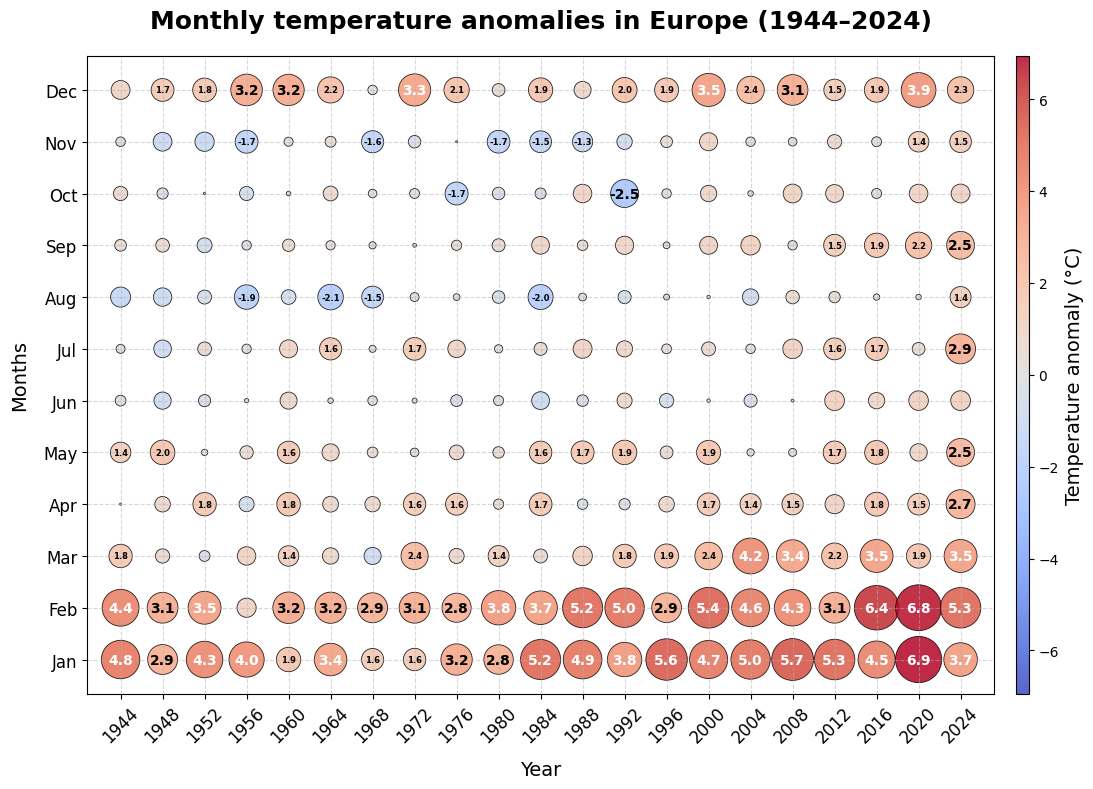

In [21]:
plt.figure(figsize=(12, 8))

X, Y = np.meshgrid(sample_years, months) 

vmax_plt = np.max(np.abs(anom_month_plt))
norm = colors.TwoSlopeNorm(vmin=-vmax_plt, vcenter=0, vmax=vmax_plt)
bubble_size = np.abs(anom_month_plt) * 160 #to enhance the bubble size, otherwise too small

sc = plt.scatter(
    X.flatten(), Y.flatten(),
    s=bubble_size.flatten(),
    c=anom_month_plt.flatten(),
    norm=norm,
    cmap='coolwarm',
    alpha=0.85,
    edgecolors='black',
    linewidth=0.6)

for i in range(len(months)):
    for j in range(len(sample_years)):
        val = anom_month_plt[i, j]
        if bubble_size[i, j] > 210:
            color = "white" if abs(val) > 3.3 else "black"
            size = 6 if abs(val) < 2.5 else 10
            plt.text(X[i, j], Y[i, j], f"{val:.1f}", fontsize=size, ha='center', va='center', color=color, fontweight='bold')
            #add the respective anomaly values to the bubbles

cbar = plt.colorbar(sc, aspect=50, pad=0.02)
cbar.set_label("Temperature anomaly (°C)", fontsize=14)

plt.xticks(sample_years, sample_years, fontsize=12, rotation=45)
plt.yticks(range(len(months)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.xlabel("Year", fontsize=14, labelpad=10)
plt.ylabel("Months", fontsize=14, labelpad=10)
plt.title("Monthly temperature anomalies in Europe (1944–2024)", fontsize=18, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.margins(x=0.04, y=0.06)

plt.tight_layout()
plt.savefig('bubbles_eu.png')
plt.show()

#### The plot shows that the colder months, December, January, February, and March, are the most affected by climate change. This reflects the broader trend where __colder regions or seasons tend to warm faster__ than already warm ones, similar to how the Arctic is warming more rapidly than the global average mentioned in the previous section. The highest anomaly was __6.9°C in January 2020__, followed by __6.8°C in February 2020__.

### __Scatter animation of the monthly temperature anomalies in Europe over the years (1940 - 2024)__

In [13]:
import matplotlib.animation as animation

Define key parameters for the animation.

In [14]:
ini = 0
yrs_frame = 10
fin = ini + yrs_frame
years_dyn = yrs[ini:fin]
anom_month_dyn = anom_month_vals[:, ini:fin]

Animate the scatter plot.

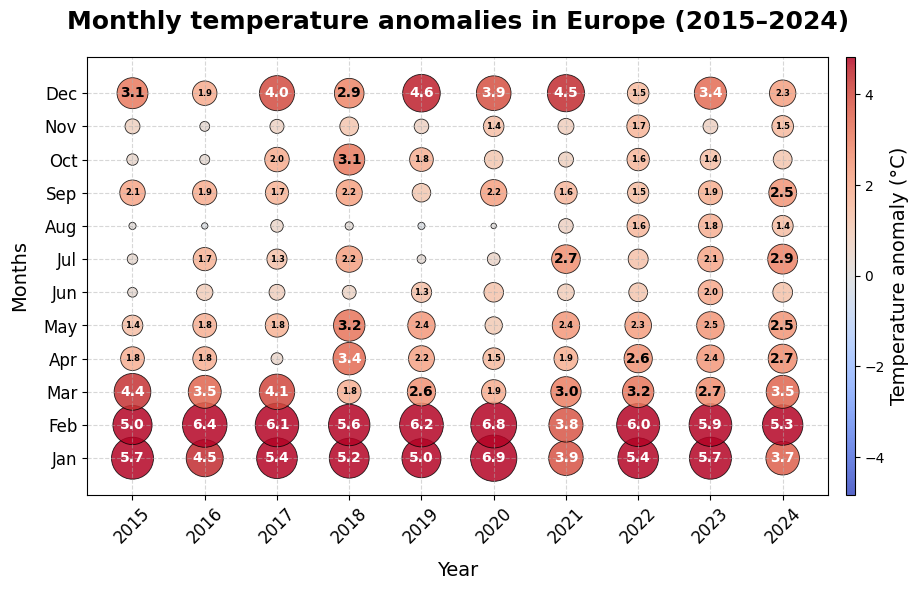

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

X, Y = np.meshgrid(years_dyn, months)

vmax = np.max(np.abs(anom_month_dyn))
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
bubble_size = np.abs(anom_month_dyn) * 160 

sc = ax.scatter(
    X.flatten(), Y.flatten(),
    s=bubble_size.flatten(),
    c=anom_month_dyn.flatten(),
    norm=norm,
    cmap='coolwarm',
    alpha=0.85,
    edgecolors='black',
    linewidth=0.6)
    
cbar = fig.colorbar(sc, ax = ax, aspect=50, pad=0.02)
cbar.set_label("Temperature anomaly (°C)", fontsize=14)

ax.set_xticks(years_dyn)
ax.set_xticklabels(years_dyn, fontsize=12, rotation=45)
ax.set_yticks(range(len(months)))
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
ax.set_xlabel("Year", fontsize=14, labelpad=10)
ax.set_ylabel("Months", fontsize=14, labelpad=10)
ax.set_title("Monthly temperature anomalies in Europe relative to 1940 (1944–2024)", fontsize=18, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.5)
ax.margins(x=0.07, y=0.1)

#define the update function
def update(frame):
    ax.clear() #clear the plot after each frame to avoid overlapping drawing
    start_idx = frame
    end_idx = frame + yrs_frame

    #update the years and displayed values
    years_dyn = yrs[start_idx:end_idx]
    anom_month_dyn = anom_month_vals[:, start_idx:end_idx]

    #update the mesh and the bubble size to avoid any errors
    X, Y = np.meshgrid(years_dyn, months) 
    bubble_size = np.abs(anom_month_dyn) * 160 

    #update the scatter plot
    sc = ax.scatter(
        X.flatten(), Y.flatten(),
        s=bubble_size.flatten(),
        c=anom_month_dyn.flatten(),
        norm=norm,
        cmap='coolwarm',
        alpha=0.85,
        edgecolors='black',
        linewidth=0.6)

    #update the axis and the title
    ax.set_xticks(years_dyn)
    ax.set_xticklabels(years_dyn, fontsize=12, rotation=45)
    ax.set_yticks(range(len(months))) 
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
    ax.set_xlabel("Year", fontsize=14, labelpad=10)
    ax.set_ylabel("Months", fontsize=14, labelpad=10)
    ax.set_title(f"Monthly temperature anomalies in Europe ({yrs[start_idx]}–{yrs[end_idx-1]})", fontsize = 18, fontweight = 'bold', pad = 20)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.margins(x=0.07, y=0.1)

    #update the displayed values of the anomalies
    for i in range(len(months)):
        for j in range(len(years_dyn)):
            val = anom_month_dyn[i, j]
            if bubble_size[i, j] > 210:
                color = "white" if abs(val) > 3.3 else "black"
                size = 6 if abs(val) < 2.5 else 10
                ax.text(X[i, j], Y[i, j], f"{val:.1f}", fontsize=size, ha='center', va='center', color=color, fontweight='bold')
    return sc

ani_frames = len(yrs) - (yrs_frame - 1) # Number of years from 1941 to 2024
ani = animation.FuncAnimation(fig, update, frames=ani_frames, interval=140, blit=False)
ani.save('bubble_ani.mp4')

plt.tight_layout()
plt.show()

#### This animation gives a more complete picture of how the monthly temperature anomalies evolved over time. The animation shows the data in __10-year intervals__, with each frame displaying a decade of temperature anomalies. It's interesting to see how the __bubbles gradually get redder and larger__ as the years pass, visually supporting the trend observed earlier, that Europe is getting warmer fast, and the anomalies are becoming more extreme, especially in the colder months.

### __Temperature plot of the yearly temperature anomalies in Europe over the years (1940 - 2024)__

In [22]:
import cartopy.crs as ccrs

Define key variables and functions.

In [23]:
europe_projection = ccrs.EuroPP() #use the Europe projection

In [24]:
#compute the mean temperature for a given year in Celsius
def mean_temp(year):
    return temp.sel(valid_time=str(year)).mean('valid_time') - 273.15 #compute in Celsius

#define the 1940 baseline
ref_1940 = mean_temp(1940)

#compute the temperature anomaly for a given year
def anom_temp(year):
    return mean_temp(year) - ref_1940 

#define the plot function for compactness and to easily adjusting parameters
def plot_temp(data, ax=None, vmin=-10, vmax=20):
    return data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax, add_colorbar=False)

Display the data in a __temperature plot__. $\\$
These temperature maps show the __mean yearly temperatures and temperature anomalies across Europe__, with each point representing the temperature or anomaly relative to 1940 at a specific location. The first two plots display the actual __temperatures for the years 1940 and 2024__, where, as usual, red indicates warmer temperatures and blue indicates colder ones. The third plot shows the __temperature anomaly in 2024 relative to 1940__, with red areas highlighting regions that with a higher anomaly. For example, when a region transitions from dark blue in 1940 to light blue or neutral in 2024, it appears as a deep red in the anomaly map, making the warming easy to spot.

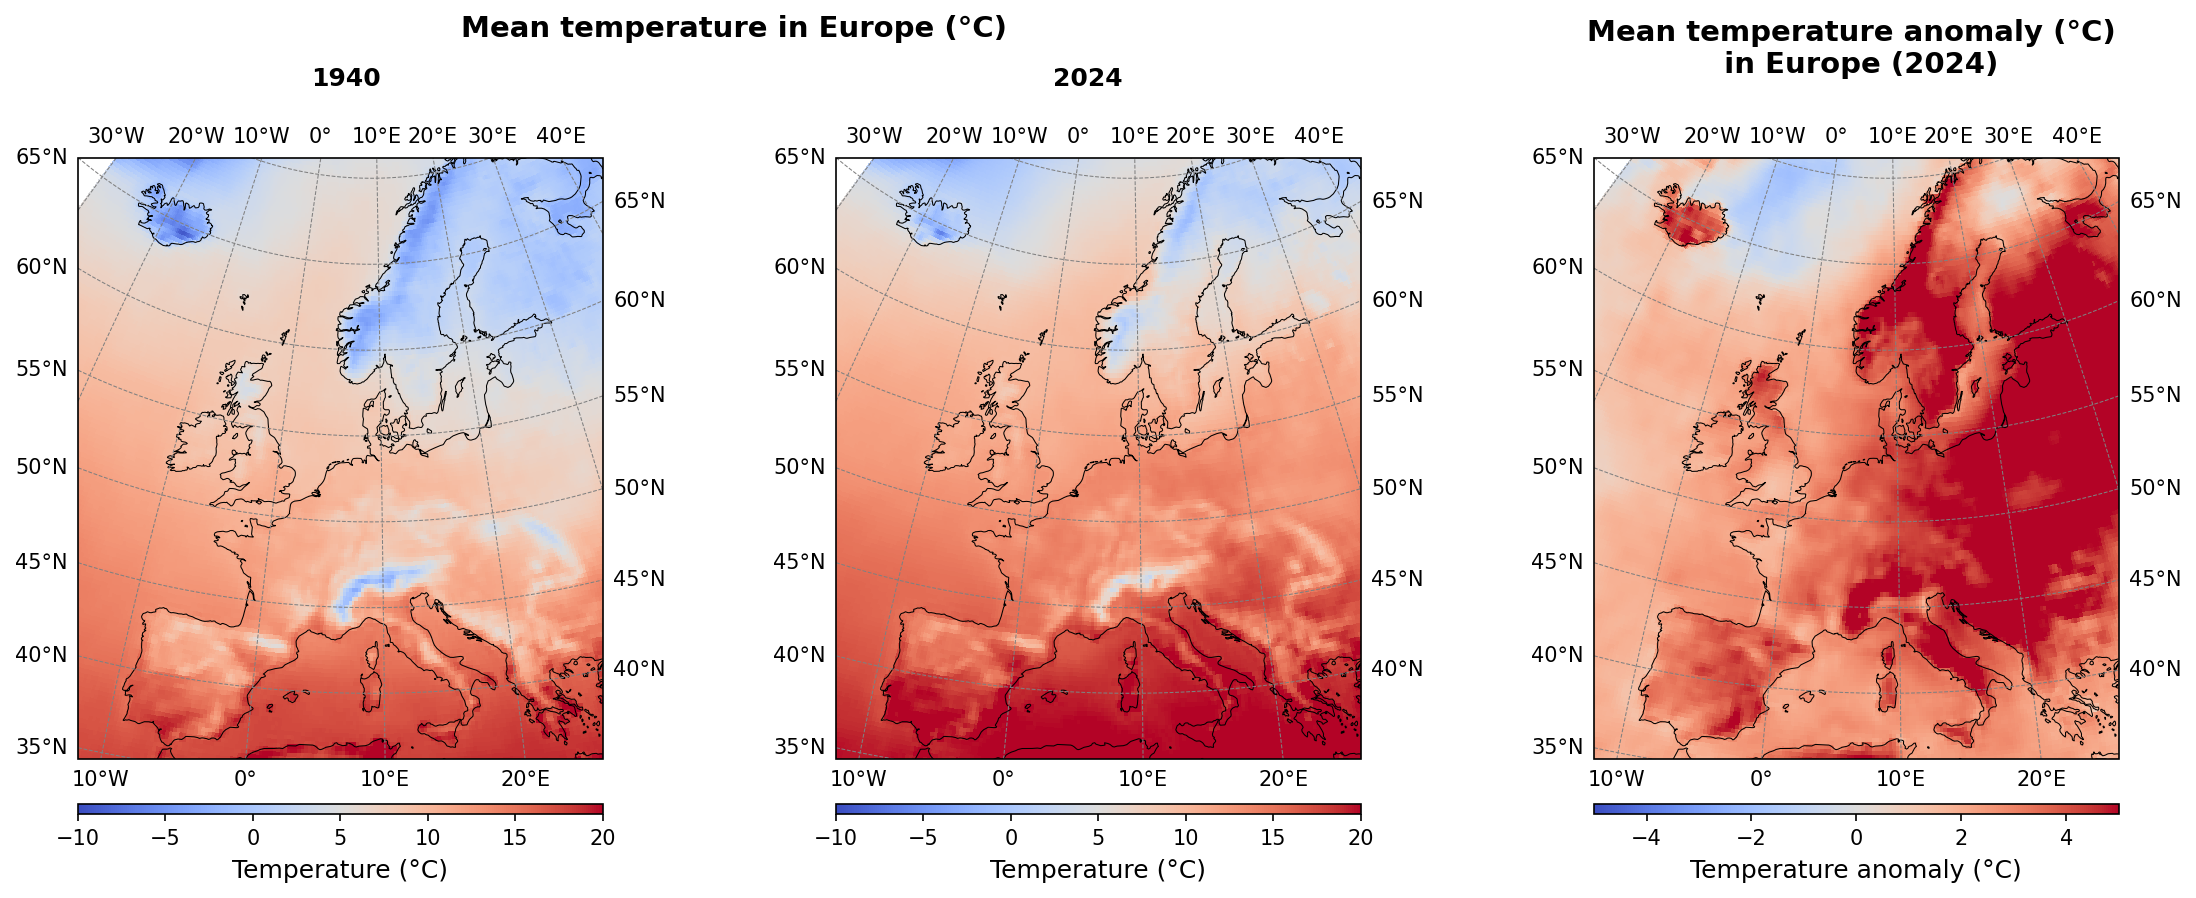

In [37]:
fig, (ax_1940, ax_2024, ax_anom) = plt.subplots(1, 3, subplot_kw={'projection': europe_projection}, dpi=150, figsize=(15, 7))

plots = [plot_temp(mean_temp(1940), ax_1940),
         plot_temp(mean_temp(2024), ax_2024),
         plot_temp(anom_temp(2024), ax_anom, vmin=-5, vmax=5)]

for ax in [ax_1940, ax_2024, ax_anom]:
    ax.coastlines(linewidth=0.5, color='black')
    ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)

for ax in [ax_1940, ax_2024]:
    cbar = fig.colorbar(plots[0], ax=ax, orientation='horizontal', pad=0.05, aspect=50)
    cbar.set_label('Temperature (°C)', fontsize=12, labelpad=5)
cbar_anom = fig.colorbar(plots[2], ax=ax_anom, orientation='horizontal', pad=0.05, aspect=50)
cbar_anom.set_label('Temperature anomaly (°C)', fontsize=12, labelpad=5)

ax_1940.set_title("Mean temperature in Europe (°C)", fontsize=14, fontweight = 'bold', x = 1.25, y = 1.18)
ax_2024.set_title('')
fig.text(0.15, 0.85, "1940", fontsize=12, fontweight='bold')
fig.text(0.48, 0.85, "2024", fontsize=12, fontweight='bold')
ax_anom.set_title("Mean temperature anomaly (°C) \n in Europe (2024)", fontsize=14, fontweight='bold', x = 0.5, y = 1.12)

plt.tight_layout(pad=2)
plt.savefig('temp_map_eu.png')
plt.show()

#### The __changes between the 1940 and 2024 maps are clearly visible__, as in 2024, many of the blue-shaded regions from 1940 have become much lighter. This difference is further highlighted in the temperature anomaly map, which shows which regions are being affected the most. As expected, colder and more northern areas, such as __the Nordic countries__, the __Baltic states__, __Iceland__, and __the Alps__, show some of the strongest warming effects, consistent with broader climate change patterns mentioned previously. However, it's not just the North: Other regions like __Italy, Eastern Europe__ and parts of __Central Europe__ also show considerable warming, highlighting that the __impacts of climate change__ are widespread and __not confined to any specific region__.